In [ ]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import keras
import matplotlib.pyplot as plt

In [ ]:
import sys
sys.path.append('/content/drive/My Drive')
from ind_rnn import IndRNNCell, RNN, IndRNN


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/My Drive/azure download/data/AzureReadings_at_a_timestamp.csv')
df['timestamp'] =  pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()

,min cpu,max cpu,avg cpu
timestamp,,,
2017-01-01 00:00:00,715146.536821,2.223302e+06,1.229569e+06
2017-01-01 00:05:00,700473.840324,2.212393e+06,1.211322e+06
2017-01-01 00:10:00,705953.565850,2.213057e+06,1.206635e+06
2017-01-01 00:15:00,688383.073221,2.187572e+06,1.190369e+06
2017-01-01 00:20:00,688276.551033,2.183684e+06,1.180992e+06


In [ ]:
dataset = df.values
dataset = dataset.astype('float32')

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

6912 1728


In [ ]:
def create_training_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :3]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 5
trainX, trainY = create_training_dataset(train, look_back=look_back)
testX, testY = create_training_dataset(test, look_back=look_back)

In [ ]:
model2 = keras.models.Sequential()
model2.add(IndRNN(128, input_shape=(trainX.shape[1], trainX.shape[2]),
                              return_sequences=False))

model2.add(keras.layers.Dense(3))

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ind_rnn_1 (IndRNN)           (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adamOpt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=[keras.metrics.mae])

In [ ]:
callback = keras.callbacks.EarlyStopping(patience=3)
history2 = model2.fit(trainX, trainY, epochs=20, validation_split=0.25, batch_size=16, verbose=2, shuffle=False)

Train on 5179 samples, validate on 1727 samples
Epoch 1/20
 - 1s - loss: 0.0015 - mean_absolute_error: 0.0259 - val_loss: 5.1684e-04 - val_mean_absolute_error: 0.0179
Epoch 2/20
 - 1s - loss: 7.3301e-04 - mean_absolute_error: 0.0189 - val_loss: 4.8492e-04 - val_mean_absolute_error: 0.0173
Epoch 3/20
 - 1s - loss: 6.4115e-04 - mean_absolute_error: 0.0177 - val_loss: 4.6287e-04 - val_mean_absolute_error: 0.0170
Epoch 4/20
 - 1s - loss: 6.0959e-04 - mean_absolute_error: 0.0173 - val_loss: 4.4891e-04 - val_mean_absolute_error: 0.0167
Epoch 5/20
 - 1s - loss: 5.8716e-04 - mean_absolute_error: 0.0170 - val_loss: 4.4950e-04 - val_mean_absolute_error: 0.0167
Epoch 6/20
 - 1s - loss: 5.7087e-04 - mean_absolute_error: 0.0168 - val_loss: 4.4217e-04 - val_mean_absolute_error: 0.0165
Epoch 7/20
 - 1s - loss: 5.6883e-04 - mean_absolute_error: 0.0168 - val_loss: 4.4249e-04 - val_mean_absolute_error: 0.0165
Epoch 8/20
 - 1s - loss: 5.6853e-04 - mean_absolute_error: 0.0168 - val_loss: 4.4811e-04 - val_

In [ ]:
model2.evaluate(testX, testY)

1722/1722 [==============================] - 0s 30us/step


[0.0005520622850488763, 0.01743340492248535]

In [ ]:
trainPredict = model2.predict(trainX)
testPredict = model2.predict(testX)

In [ ]:
trainY = scaler.inverse_transform(trainY)
trainPredict = scaler.inverse_transform(trainPredict)
testY = scaler.inverse_transform(testY)
testPredict = scaler.inverse_transform(testPredict)

In [ ]:
trainScore = math.sqrt(mean_squared_error(trainY[:], trainPredict[:]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 28729.09 RMSE
Test Score: 29480.69 RMSE


In [ ]:
from sklearn.metrics import mean_absolute_error
trainScore = (mean_absolute_error(trainY[:], trainPredict[:]))
print('Train Score: %f MAE' % (trainScore))
testScore = math.sqrt(mean_absolute_error(testY[:], testPredict[:]))
print('Test Score: %f MAE' % (testScore))

Train Score: 17086.007812 MAE
Test Score: 136.790292 MAE


In [ ]:
trainScore2 = np.mean(np.abs(trainPredict - trainY)/np.abs(trainY))
print('Train Score: %f MAPE' % (trainScore2))
testScore2 = np.mean(np.abs(testPredict - testY)/np.abs(testY))
print('Test Score: %f MAPE' % (testScore2))

Train Score: 0.011730 MAPE
Test Score: 0.012492 MAPE


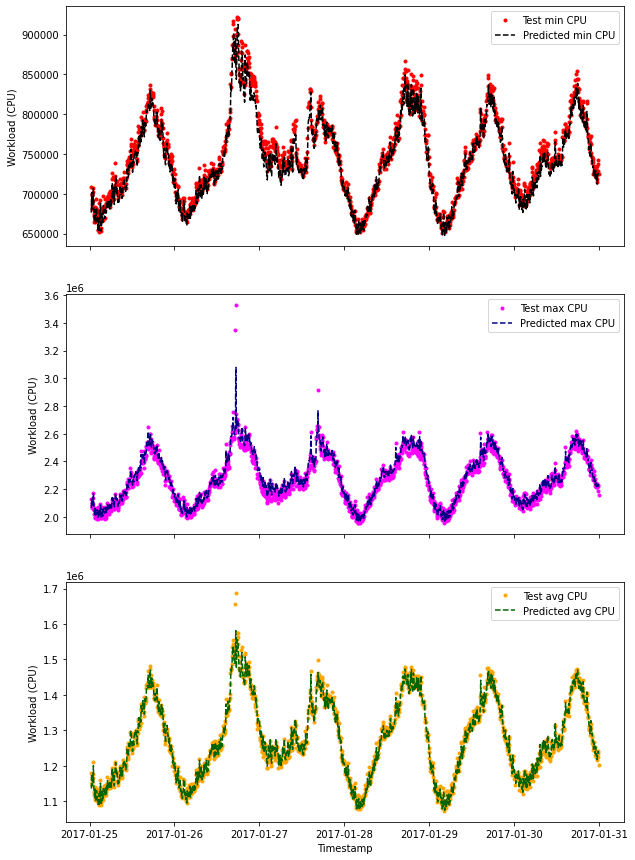

In [ ]:

index=df.index
TestY= pd.DataFrame(testY,columns=['min_cpu','max_cpu','avg_cpu'])
PredY=pd.DataFrame(testPredict,columns=['min_cpu','max_cpu','avg_cpu'])

x=index[-1722:]
fig, axs = plt.subplots(3,figsize=(10,15))

axs[0].plot(x,TestY.min_cpu,'.',label='Test min CPU',color='red')
axs[0].plot(x,PredY.min_cpu,'--',label='Predicted min CPU',color='black')
axs[0].legend()
axs[1].plot(x,TestY.max_cpu,'.',label='Test max CPU',color='magenta')
axs[1].plot(x,PredY.max_cpu,'--',label='Predicted max CPU',color='navy')
axs[1].legend()
axs[2].plot(x,TestY.avg_cpu,'.',label='Test avg CPU',color='orange')
axs[2].plot(x,PredY.avg_cpu,'--',label='Predicted avg CPU',color='darkgreen')
axs[2].legend()
for ax in axs.flat:
    ax.set(xlabel='Timestamp', ylabel='Workload (CPU)',autoscale_on=True)
for ax in axs:
    ax.label_outer()
#fig.suptitle('Prediction of Workload on Azure cloud at a particular timestamp',fontsize=20)
plt.savefig('/content/drive/My Drive/azure download/data/indRnn output.png', dpi = 300)
plt.show()